## Fitting a SARIMA Model for VIX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import kpss
from itertools import product
import warnings
warnings.filterwarnings('ignore')

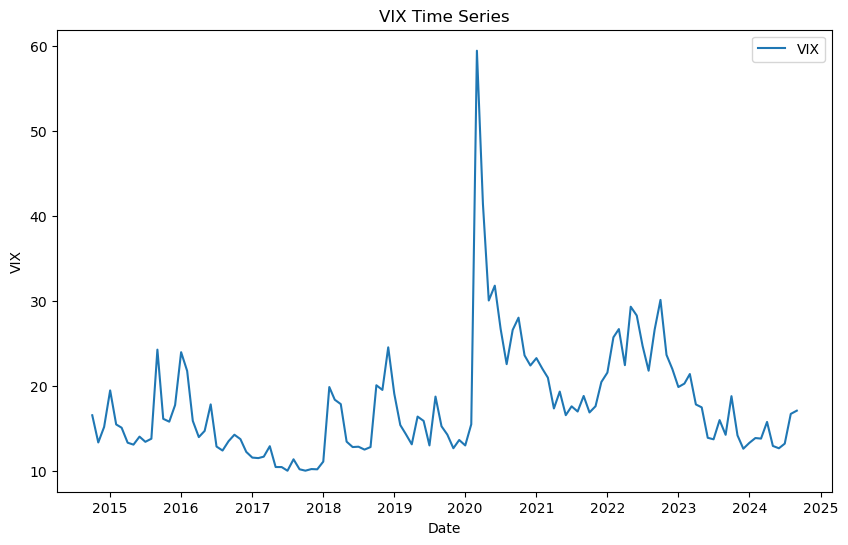

In [2]:
# Load the VIX data
# Assuming you have a CSV file with VIX data
all_data = pd.read_csv('vix_data.csv', index_col='Date', parse_dates=True)
vix_data = all_data[['VIX']]
vix_data = vix_data.dropna()
vix_training = vix_data[:'2023']

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(vix_data, label='VIX')
plt.title('VIX Time Series')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
plt.show()

ADF Statistic: -4.730998322189474
p-value: 7.356482968455145e-05
KPSS Statistic: 0.4453092563436814
p-value: 0.057625320541516645
PP Statistic: -5.117761487666616
p-value: 1.2910798243798172e-05


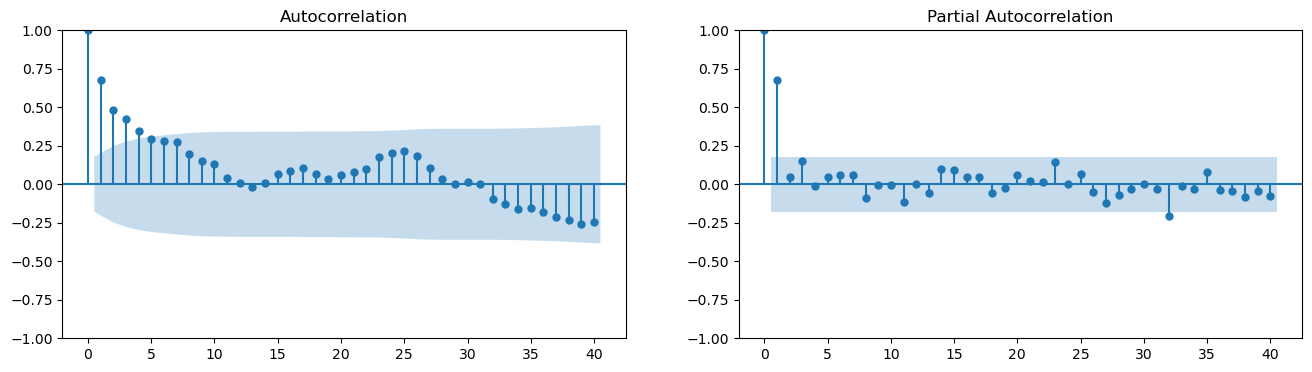

In [3]:
# Run tests to check if the data is stationary
## ADF Test
result = adfuller(vix_data['VIX'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## KPSS Test
result = kpss(vix_data['VIX'],regression='c', nlags="auto")
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

## PP Test
result = PhillipsPerron(vix_data['VIX'])
print('PP Statistic:', result.stat)
print('p-value:', result.pvalue)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig = sm.graphics.tsa.plot_acf(vix_data['VIX'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(vix_data['VIX'], lags=40, ax=axes[1])
plt.show()

ADF Statistic: -10.78088274132635
p-value: 2.2568472890567784e-19
KPSS Statistic: 0.09776853861923743
p-value: 0.1
PP Statistic: -17.36495093265605
p-value: 5.1776297173536184e-30


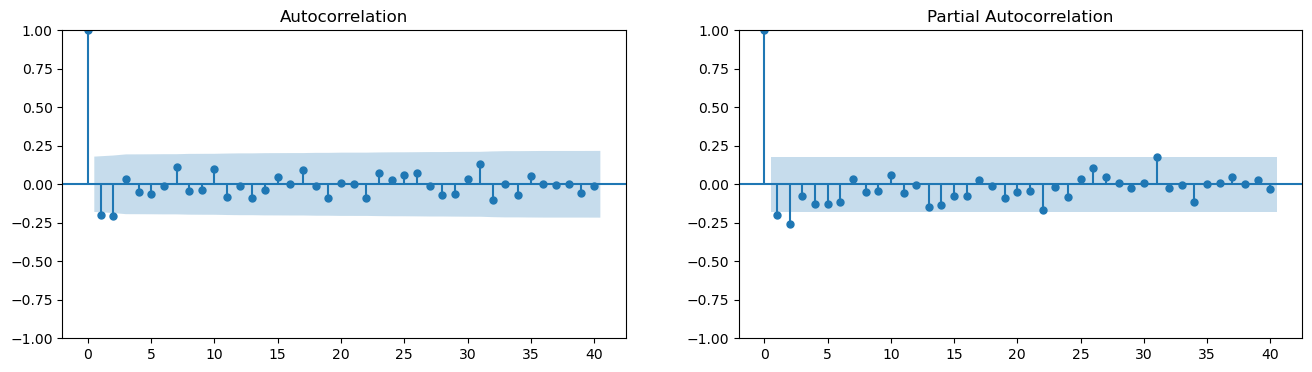

In [4]:
# Difference the data and run the tests again
vix_data['VIX_diff'] = vix_data['VIX'].diff()
vix_data = vix_data.dropna()

## ADF Test
result = adfuller(vix_data['VIX_diff'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

## KPSS Test
result = kpss(vix_data['VIX_diff'],regression='c', nlags="auto")
print('KPSS Statistic:', result[0])
print('p-value:', result[1])

## PP Test
result = PhillipsPerron(vix_data['VIX_diff'])
print('PP Statistic:', result.stat)
print('p-value:', result.pvalue)

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
fig = sm.graphics.tsa.plot_acf(vix_data['VIX_diff'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(vix_data['VIX_diff'], lags=40, ax=axes[1])
plt.show()

In [5]:
# Split the data into train and test sets
train_size = int(len(vix_data) * 0.9)  # Use 80% of data for training
train, test = vix_data.iloc[:train_size], vix_data.iloc[train_size:]

In [6]:
# Define parameter ranges for grid search
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = [12]
param_grid = list(product(p, d, q, P, D, Q, s))
best_aic, best_bic = float('inf'), float('inf')
best_params_aic, best_params_bic = None, None


In [7]:
for params in param_grid:
    try:
        model = SARIMAX(
            train['VIX'], 
            order=(params[0], params[1], params[2]),
            seasonal_order=(params[3], params[4], params[5], params[6]),
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        # Collect AIC and BIC scores
        aic = model_fit.aic
        bic = model_fit.bic

        # Update best AIC model
        if aic < best_aic:
            best_aic, best_params_aic = aic, params
            print(f"New Best AIC: {aic:.4f} | Params: {params}")

        # Update best BIC model
        if bic < best_bic:
            best_bic, best_params_bic = bic, params
            print(f"New Best BIC: {bic:.4f} | Params: {params}")

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

New Best AIC: 932.3369 | Params: (0, 0, 0, 0, 0, 0, 12)
New Best BIC: 935.0003 | Params: (0, 0, 0, 0, 0, 0, 12)
New Best AIC: 790.6301 | Params: (0, 0, 0, 0, 0, 1, 12)
New Best BIC: 795.7167 | Params: (0, 0, 0, 0, 0, 1, 12)
New Best AIC: 661.8872 | Params: (0, 0, 0, 0, 0, 2, 12)
New Best BIC: 669.1073 | Params: (0, 0, 0, 0, 0, 2, 12)
New Best AIC: 587.2451 | Params: (0, 0, 0, 0, 1, 1, 12)
New Best BIC: 592.0585 | Params: (0, 0, 0, 0, 1, 1, 12)
New Best AIC: 561.6120 | Params: (0, 0, 0, 0, 2, 1, 12)
New Best BIC: 566.1090 | Params: (0, 0, 0, 0, 2, 1, 12)
New Best AIC: 559.9833 | Params: (0, 0, 0, 1, 2, 0, 12)
New Best BIC: 564.5087 | Params: (0, 0, 0, 1, 2, 0, 12)
New Best AIC: 531.8692 | Params: (0, 0, 0, 1, 2, 1, 12)
New Best BIC: 538.6147 | Params: (0, 0, 0, 1, 2, 1, 12)
New Best AIC: 513.0814 | Params: (0, 0, 0, 2, 1, 0, 12)
New Best BIC: 519.8694 | Params: (0, 0, 0, 2, 1, 0, 12)
New Best AIC: 463.4828 | Params: (0, 0, 0, 2, 2, 0, 12)
New Best BIC: 469.7154 | Params: (0, 0, 0, 2, 2,

In [11]:
print(f"\nBest AIC Model: {best_params_aic} | AIC: {best_aic:.4f}")
print(f"Best BIC Model: {best_params_bic} | BIC: {best_bic:.4f}")


Best AIC Model: (2, 2, 2, 2, 2, 1, 12) | AIC: 418.5090
Best BIC Model: (2, 1, 0, 2, 2, 1, 12) | BIC: 432.3134


In [12]:
# Fit the SARIMA model
model = SARIMAX(train['VIX'], order=(best_params_aic[0], best_params_aic[1], best_params_aic[2]), seasonal_order=(best_params_aic[3], best_params_aic[4], best_params_aic[5], best_params_aic[6]), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)

# Forecast the next steps (length of the test set)
forecast_steps = len(test)
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

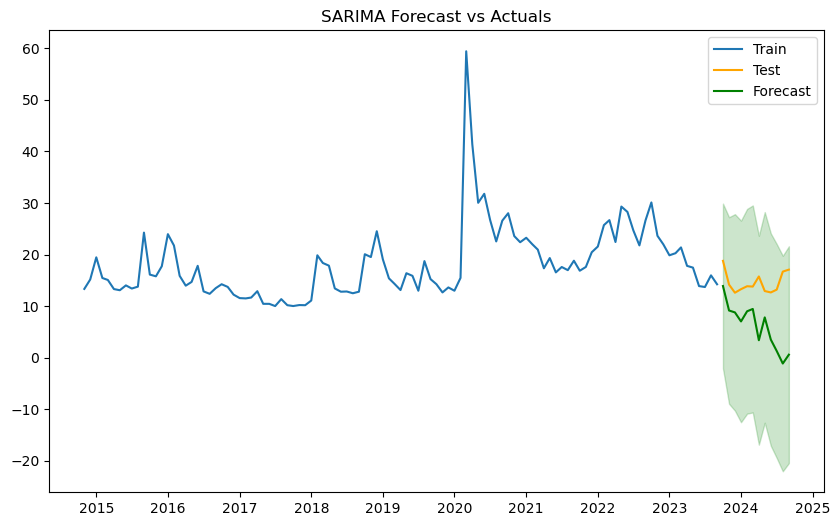

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['VIX'], label='Train')
plt.plot(test.index, test['VIX'], label='Test', color='orange')
plt.plot(test.index, forecast_mean, label='Forecast', color='green')
plt.fill_between(
    test.index, 
    forecast_conf_int.iloc[:, 0], 
    forecast_conf_int.iloc[:, 1], 
    color='green', alpha=0.2
)
plt.legend()
plt.title('SARIMA Forecast vs Actuals')
plt.show()

In [15]:
# Calculate the RMSE, MAPE, R2, and Directional Accuracy
rmse = root_mean_squared_error(test['VIX'], forecast_mean)
mape = np.mean(np.abs(test['VIX'] - forecast_mean) / np.abs(test['VIX'])) * 100
r2 = r2_score(test['VIX'], forecast_mean)
directional_accuracy = np.mean(np.sign(test['VIX'].diff().dropna()) == np.sign(forecast_mean.diff().dropna())) * 100
print(f"RMSE: {rmse:.4f}, MAPE: {mape:.4f}, R2: {r2:.4f}, Directional Accuracy: {directional_accuracy:.4f}")

RMSE: 9.7433, MAPE: 57.4553, R2: -24.3143, Directional Accuracy: 45.4545
